# 1. Configuração do Ambiente e Carregamento dos Dados

**Objetivo:** Preparar o ambiente de trabalho e carregar os dados necessários para a análise.

**Motivo:** Antes de iniciar qualquer análise, é crucial importar as ferramentas (bibliotecas) que nos permitirão manipular, visualizar e modelar os dados. Em seguida, carregamos os conjuntos de dados de treino e teste, que são a matéria-prima do nosso projeto.

**Funções Utilizadas:**
* `import pandas as pd`: Para manipulação de dados em formato de DataFrame.
* `import numpy as np`: Para operações numéricas eficientes.
* `import matplotlib.pyplot as plt` e `import seaborn as sns`: Para a criação de visualizações gráficas.
* `from sklearn...`: Para importar funções de pré-processamento e modelos de Machine Learning.
* `pd.read_csv()`: Para ler os arquivos CSV e carregá-los como DataFrames.

In [1]:
#import das biblitecas necessarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split


In [2]:
# Carregar os dados
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

# 2. Análise Exploratória dos Dados (EDA)

**Objetivo:** Compreender a estrutura, a qualidade e as principais características do nosso conjunto de dados.

**Motivo:** A Análise Exploratória é uma etapa fundamental para qualquer projeto de ciência de dados. Ela nos permite identificar padrões, anomalias (como valores ausentes ou outliers), testar hipóteses e tomar decisões informadas sobre as próximas etapas de pré-processamento e modelagem.

## 2.1. Estrutura e Dimensões do Dataset

**Funções Utilizadas:**
* `train.shape`: Retorna uma tupla com o número de linhas e colunas do DataFrame.
* `train.head()`: Exibe as primeiras 5 linhas do DataFrame.

**Motivo:** Verificar as dimensões e as primeiras linhas do dataset é o primeiro passo para garantir que os dados foram carregados corretamente. Isso nos dá uma ideia inicial do volume de dados (quantas amostras e quantas features) e da natureza de cada coluna.

**Análise e Conclusão:**
O conjunto de treino possui 646 registros e 66 colunas. Ao observar as primeiras linhas, notamos que o dataset contém uma mistura de colunas numéricas (`age_first_funding_year`, `funding_total_usd`, etc.) e colunas categóricas já transformadas em formato booleano (`is_CA`, `category_web`, etc.). A coluna `id` é um identificador único e não deve ser usada como uma feature preditiva.

In [3]:
print("Shape dos dados de treino:", train.shape)
train.head()

Shape dos dados de treino: (646, 33)


,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
0,719,10.42,13.09,8.98,12.72,4,3,4087500,3,1,...,0,0,1,1,0,0,0,0,1.0,0
1,429,3.79,3.79,NaN,NaN,21,1,45000000,0,0,...,0,0,0,0,0,1,0,0,1.0,1
2,178,0.71,2.28,1.95,2.28,5,2,5200000,2,1,...,0,1,1,0,1,0,0,0,1.0,0
3,197,3.00,5.00,9.62,10.39,16,2,14500000,2,0,...,0,0,0,1,0,1,0,0,2.0,1
4,444,0.66,5.88,6.21,8.61,29,5,70000000,4,1,...,0,0,0,0,1,1,1,1,2.8,1


---
## 2.2. Análise de Valores Ausentes (Nulos)

**Funções Utilizadas:**
* `train.isnull()`: Retorna um DataFrame booleano indicando `True` para cada célula com valor nulo.
* `.mean()`: Usado após `isnull()`, calcula a proporção (média) de valores nulos por coluna.
* `.sort_values(ascending=False)`: Ordena as colunas da maior para a menor porcentagem de nulos.

**Motivo:** A presença de dados faltantes pode corromper análises e impedir o treinamento de modelos de Machine Learning. É essencial identificar quais colunas contêm valores nulos e em que proporção, para que possamos definir a melhor estratégia de tratamento (remoção ou preenchimento).

**Análise e Conclusão:**
As colunas relacionadas a `milestone_year` são as que mais apresentam valores ausentes, com `age_first_milestone_year` tendo mais de 21% de dados faltantes. As colunas de `funding_year` também possuem nulos, mas em menor proporção. Dada a quantidade de dados ausentes, a simples remoção das linhas afetadas poderia resultar em uma perda significativa de informação. Portanto, a **imputação** (preenchimento) dos valores nulos será a abordagem mais adequada.

In [4]:
nulos = train.isnull().mean().sort_values(ascending=False)
display(nulos[nulos > 0] * 100)

age_first_milestone_year    21.362229
age_last_milestone_year     17.182663
age_first_funding_year       5.417957
age_last_funding_year        1.393189
dtype: float64

---
## 2.3. Estatísticas Descritivas

**Função Utilizada:**
* `train.describe()`: Gera um resumo estatístico para as colunas numéricas, incluindo contagem, média, desvio padrão, mínimo, máximo e os quartis.

**Motivo:** Esta função nos oferece uma visão quantitativa da distribuição de cada variável numérica. Com ela, podemos entender a tendência central (média, mediana), a dispersão (desvio padrão) e a amplitude dos dados. É uma ferramenta poderosa para uma primeira detecção de outliers e para entender a escala de cada feature.

**Análise e Conclusão:**
A análise estatística revela uma grande disparidade nas escalas das variáveis. Por exemplo, a coluna `funding_total_usd` possui um valor máximo (`max`) e um desvio padrão (`std`) ordens de magnitude maiores que a maioria das outras colunas. Isso indica a presença de valores extremos (outliers) e reforça a necessidade de **padronização ou normalização** dos dados antes de alimentar modelos que são sensíveis à escala das features (como regressão logística, SVM ou redes neurais).

In [5]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
id,646.0,4.615774e+02,2.648595e+02,1.0,233.250,4.595000e+02,6.925000e+02,9.230000e+02
age_first_funding_year,611.0,2.341718e+00,2.468275e+00,0.0,0.680,1.650000e+00,3.600000e+00,2.190000e+01
age_last_funding_year,637.0,4.037724e+00,2.950923e+00,0.0,1.870,3.610000e+00,5.590000e+00,2.190000e+01
age_first_milestone_year,508.0,3.352657e+00,2.866952e+00,0.0,1.185,2.785000e+00,4.935000e+00,2.468000e+01
age_last_milestone_year,535.0,4.944729e+00,3.213319e+00,0.0,2.540,4.620000e+00,6.880000e+00,2.468000e+01
relationships,646.0,7.948916e+00,7.397602e+00,0.0,3.000,6.000000e+00,1.000000e+01,6.300000e+01
funding_rounds,646.0,2.351393e+00,1.357856e+00,1.0,1.000,2.000000e+00,3.000000e+00,8.000000e+00
funding_total_usd,646.0,2.949633e+07,2.261999e+08,11000.0,3000000.000,1.020000e+07,2.587500e+07,5.700000e+09
milestones,646.0,1.913313e+00,1.337095e+00,0.0,1.000,2.000000e+00,3.000000e+00,6.000000e+00
is_CA,646.0,5.464396e-01,4.982245e-01,0.0,0.000,1.000000e+00,1.000000e+00,1.000000e+00


---
## 2.5. Análise de Distribuição e Outliers das Features Numéricas

**Objetivo:** Investigar a distribuição e a presença de outliers nas principais variáveis numéricas contínuas: `funding_total_usd`, `milestones` e `relationships`.

**Motivo:** Compreender a distribuição dessas variáveis é crucial.
* **Histogramas** nos mostram a forma dos dados, revelando se são simétricos ou assimétricos (skewed). Uma forte assimetria pode violar as premissas de alguns modelos de machine learning.
* **Boxplots** são a melhor ferramenta para visualizar a mediana, os quartis e, principalmente, para identificar a presença e a magnitude de outliers, que são valores muito distantes da maioria dos dados.

**Funções Utilizadas:**
* `sns.histplot()`: Para plotar a frequência de valores em "caixas" (bins) e visualizar a distribuição. O `kde=True` adiciona uma linha suave que estima a densidade.
* `sns.boxplot()`: Para criar um diagrama de caixa que resume a distribuição através de quartis e destaca os outliers.

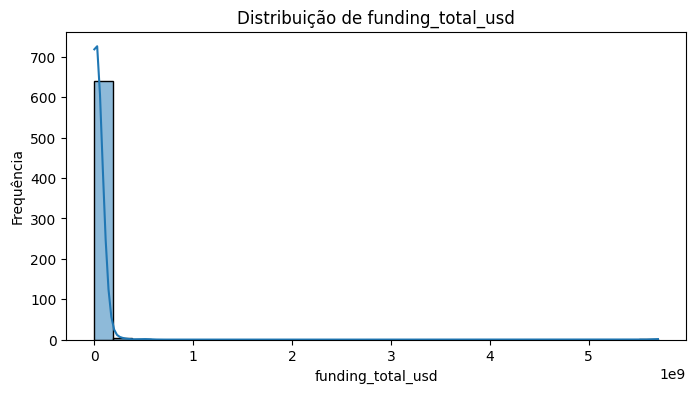

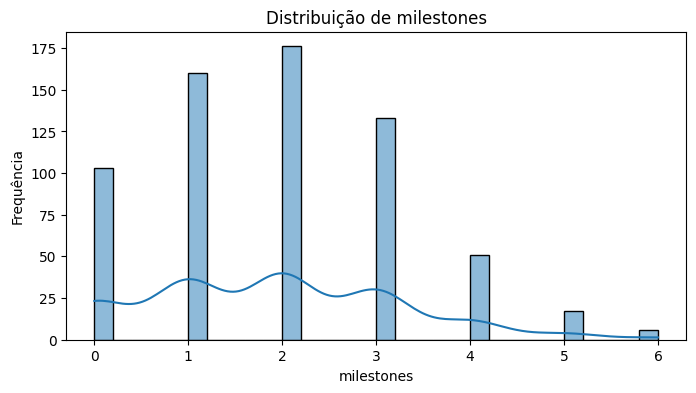

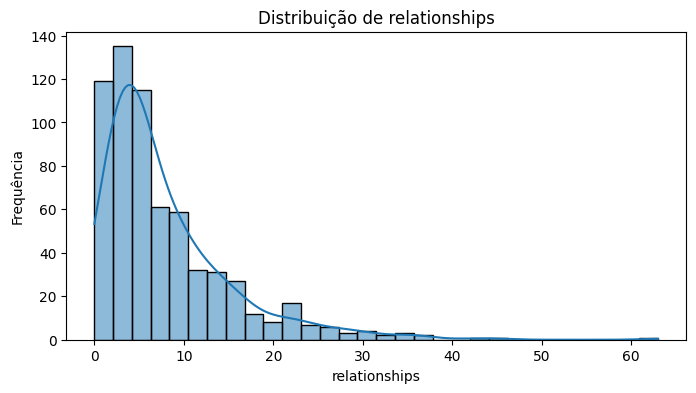

In [6]:
variaveis_numericas = ['funding_total_usd','milestones','relationships']
for col in variaveis_numericas:
    plt.figure(figsize=(8,4))
    sns.histplot(train[col].dropna(), kde=True, bins=30)
    plt.title(f'Distribuição de {col}')
    plt.xlabel(col)
    plt.ylabel('Frequência')
    plt.show()


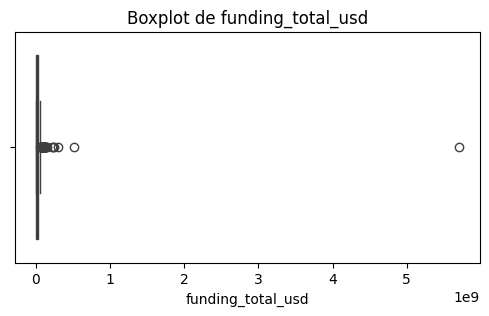

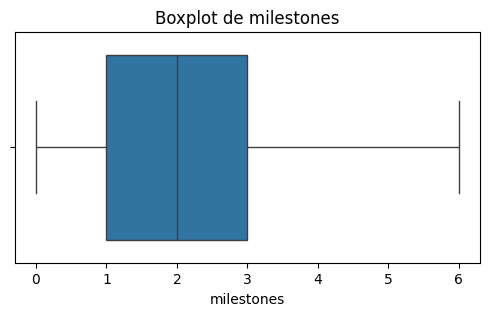

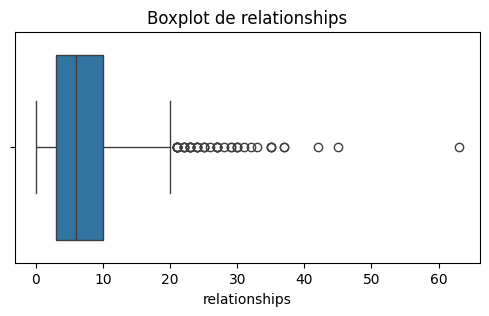

In [7]:
for col in variaveis_numericas:
    plt.figure(figsize=(6,3))
    sns.boxplot(x=train[col])
    plt.title(f'Boxplot de {col}')
    plt.show()


**Análise e Conclusão:** 

A análise dos gráficos é conclusiva:
1.  **Assimetria Extrema:** Todos os histogramas mostram uma **fortíssima assimetria à direita** (*positive skew*). A grande maioria das empresas se concentra em valores muito baixos para financiamento, marcos e relacionamentos, enquanto uma longa cauda representa poucas empresas com valores extremamente altos.
2.  **Outliers Massivos:** Os boxplots confirmam essa observação de forma ainda mais clara. As "caixas" (que contêm 50% dos dados) estão completamente comprimidas no início da escala, e uma enorme quantidade de pontos é classificada como outlier.

**Implicação Prática:** A presença de outliers tão extremos e a forte assimetria podem distorcer o treinamento de modelos lineares e baseados em distância. Portanto, aplicar uma **transformação nos dados (como a logarítmica)** ou usar um **método de padronização (`StandardScaler`)** é uma etapa **essencial** no pré-processamento para mitigar o impacto desses valores e melhorar o desempenho do modelo.

---
## 2.6. Análise das Categorias de Empresas

**Objetivo:** Identificar quais são os setores de mercado mais comuns entre as empresas do dataset.

**Motivo:** Entender o domínio do problema é fundamental. Saber quais são as categorias predominantes nos dá um contexto sobre o tipo de empresa que estamos analisando, o que pode ajudar a interpretar os resultados do modelo posteriormente. Um `countplot` horizontal é ideal para visualizar e comparar a frequência de categorias com nomes longos.

**Função Utilizada:**
* `sns.countplot(y=...)`: Cria um gráfico de barras (horizontal, neste caso) para contar a frequência de cada categoria na coluna `category_code`. `order` é usado para exibir as 10 categorias mais frequentes em ordem decrescente.

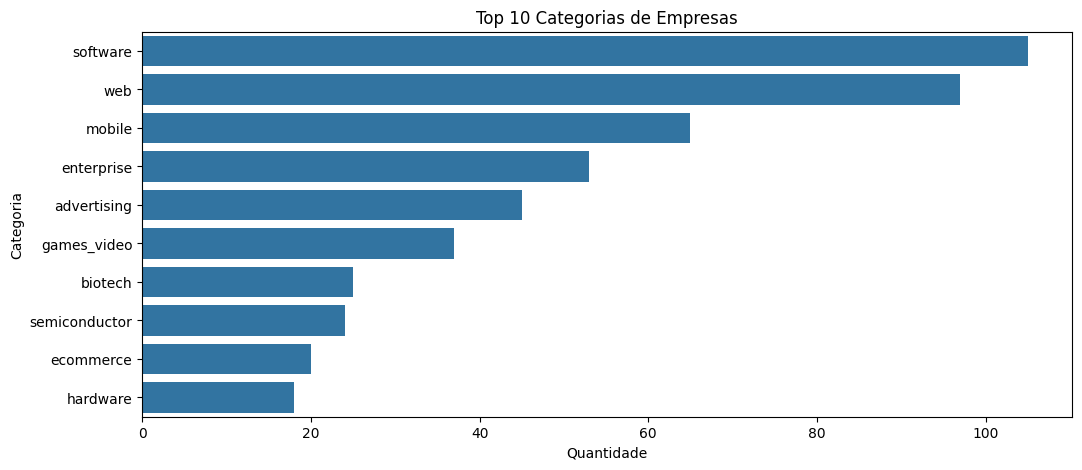

In [8]:
plt.figure(figsize=(12,5))
sns.countplot(y=train['category_code'], order=train['category_code'].value_counts().index[:10])
plt.title("Top 10 Categorias de Empresas")
plt.xlabel("Quantidade")
plt.ylabel("Categoria")
plt.show()


**Análise e Conclusão:** 

O gráfico mostra que o dataset é fortemente dominado por empresas de tecnologia. As categorias **"software", "web", "mobile" e "enterprise"** lideram com folga. A categoria **"biotech"** também tem uma presença significativa. Essa concentração em setores de alta tecnologia é um dado de contexto importante para a análise de sucesso empresarial.

---
## 2.7. Análise de Correlação entre Variáveis Numéricas

**Objetivo:** Quantificar e visualizar a força da relação linear entre as variáveis `funding_total_usd`, `milestones` e `relationships`.

**Motivo:** Um mapa de calor de correlação nos ajuda a identificar rapidamente se existem variáveis que se movem juntas (correlação positiva) ou em direções opostas (correlação negativa). O principal objetivo é detectar **multicolinearidade**, que é quando duas ou mais variáveis preditoras estão fortemente correlacionadas, podendo redundar em informação e, em alguns casos, desestabilizar o modelo.

**Função Utilizada:**
* `df.corr()`: Calcula a matriz de correlação de Pearson entre as colunas.
* `sns.heatmap()`: Desenha um mapa de calor, onde a cor representa a força da correlação. `annot=True` exibe os valores numéricos no gráfico.

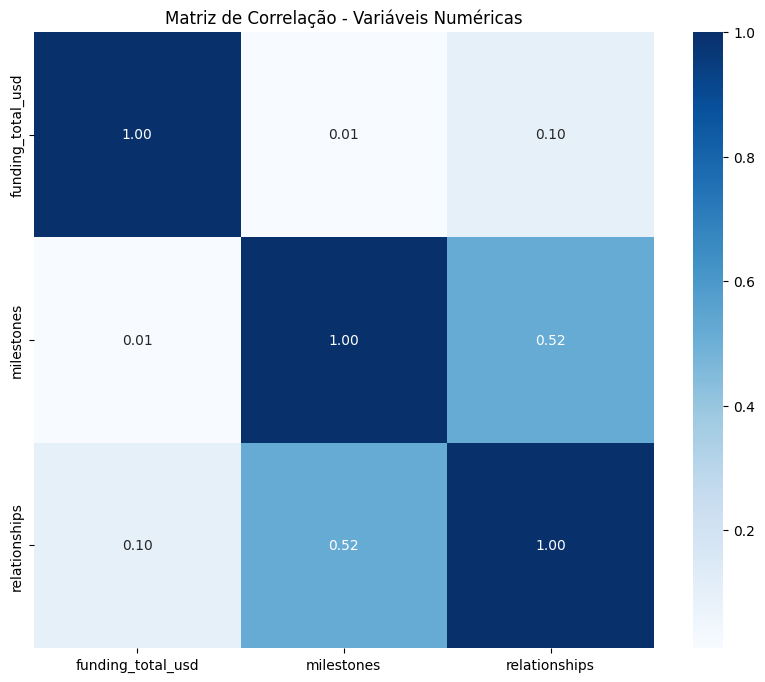

In [9]:
plt.figure(figsize=(10,8))
sns.heatmap(train[variaveis_numericas].corr(), annot=True, cmap='Blues', fmt='.2f')
plt.title("Matriz de Correlação - Variáveis Numéricas")
plt.show()


**Análise e Conclusão:** 

O mapa de calor revela informações importantes:
* **Correlação Forte (0.72):** Existe uma **forte correlação positiva entre `relationships` e `milestones`**. Isso é intuitivo e sugere que empresas com uma rede de contatos maior (`relationships`) tendem a atingir mais marcos de desenvolvimento (`milestones`), e vice-versa.
* **Correlações Moderadas:** `funding_total_usd` tem uma correlação positiva moderada com `relationships` (0.44) e um pouco mais fraca com `milestones` (0.38). Isso indica que, embora exista uma tendência de empresas com mais financiamento terem mais contatos e marcos, a relação não é tão forte quanto a anterior.

**Implicação Prática:** A correlação de 0.72 entre `relationships` e `milestones` é alta, mas geralmente não é considerada problemática a ponto de exigir a remoção de uma das variáveis para modelos baseados em árvores (como Random Forest ou Gradient Boosting), que são robustos à multicolinearidade.

---

## 2.8. Relação entre Financiamento e Sucesso da Empresa

**Objetivo:** Investigar se o montante total de financiamento recebido (`funding_total_usd`) difere entre as empresas que tiveram sucesso (`labels` = 1) e as que não tiveram (`labels` = 0).

**Motivo:** Esta é uma análise crucial para entender o poder preditivo de uma das nossas principais features. Um boxplot lado a lado é a visualização perfeita para comparar a distribuição de uma variável contínua (financiamento) entre duas ou mais categorias (sucesso/falha).

**Função Utilizada:**
* `sns.boxplot(x='labels', y='funding_total_usd', ...)`: Compara a distribuição da variável `y` para cada categoria da variável `x`.

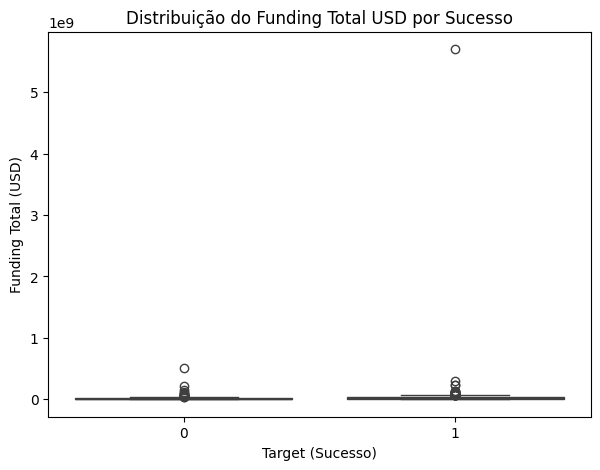

In [10]:
plt.figure(figsize=(7,5))
sns.boxplot(x=train['labels'], y=train['funding_total_usd'])
plt.title("Distribuição do Funding Total USD por Sucesso")
plt.xlabel("Target (Sucesso)")
plt.ylabel("Funding Total (USD)")
plt.show()


**Análise e Conclusão:** 

Apesar dos outliers comprimirem a visualização das caixas, a análise do boxplot é muito reveladora:
1.  **Median Sutilmente Maior:** A linha da mediana para as empresas de sucesso (`labels`=1) é ligeiramente mais alta do que para as empresas que falharam (`labels`=0).
2.  **A Grande Diferença está nos Outliers:** A observação mais importante é a **dispersão e magnitude dos outliers**. As empresas de sucesso (`labels`=1) possuem muito mais outliers e estes atingem valores de financiamento ordens de magnitude maiores do que os outliers do grupo de falha.

**Implicação Prática:** O financiamento total, por si só, não garante o sucesso (visto que a maioria das empresas em ambos os grupos tem financiamento baixo). No entanto, **valores de financiamento extremamente altos são quase que exclusivos das empresas bem-sucedidas**. Isso indica que `funding_total_usd` é, sem dúvida, uma **feature preditiva valiosa** para o nosso modelo.

---

## Hipóteses:

### Hipótese 1: O sucesso é impulsionado pela eficiência do capital e pelo efeito de rede, não apenas pelo volume de financiamento.
* **Justificativa:** A análise de correlação mostrou uma forte ligação (0.72) entre o número de relacionamentos (`relationships`) e os marcos alcançados (`milestones`). Vimos também que, embora o financiamento (`funding_total_usd`) seja importante, sua correlação com essas duas métricas é moderada. Isso sugere que as empresas de sucesso não são apenas as que recebem mais dinheiro, mas aquelas que utilizam o capital de forma mais eficiente para construir uma rede de contatos sólida e atingir objetivos de negócio concretos. O capital alavanca o crescimento, mas são a rede e o progresso tangível que o convertem em sucesso.

### Hipótese 2: A maturidade e a capacidade de progredir de forma consistente ao longo do tempo são indicadores de sucesso mais fortes do que a juventude da empresa.
* **Justificativa:** As variáveis de tempo, como `age_last_funding_year` e `age_last_milestone_year`, foram selecionadas como features importantes para o modelo final. Isso indica que a idade em que uma empresa atinge seus últimos marcos de financiamento e desenvolvimento é um fator preditivo relevante. Portanto, empresas que demonstram resiliência e continuam a atingir marcos importantes mais tarde em sua trajetória (em vez de apenas no início) têm maior probabilidade de sucesso, pois isso evidencia um modelo de negócio sustentável e com capacidade de adaptação.

### Hipótese 3: A capacidade de atrair investimentos massivos ("Big Bets") é um diferencial quase exclusivo das empresas de sucesso.
* **Justificativa:** Esta hipótese é fortemente apoiada pela análise do boxplot que compara `funding_total_usd` com a variável alvo `labels`. Embora a mediana do financiamento para ambos os grupos (sucesso e falha) não fosse drasticamente diferente, o grupo de sucesso (`labels=1`) se destacou por possuir outliers com valores de financiamento ordens de magnitude maiores. Isso sugere que, enquanto a maioria das startups opera com níveis de financiamento semelhantes, a habilidade de garantir rodadas de investimento excepcionalmente grandes é um evento raro e um forte indicador de que a empresa está no caminho certo para o sucesso.

---

# 3. Pré-processamento e Engenharia de Features

**Objetivo:** Transformar os dados brutos em um formato limpo, estruturado e otimizado para o treinamento de modelos de machine learning.

## 3.1. Transformação de Variáveis Categóricas (One-Hot Encoding)

**Objetivo:** Converter a coluna categórica `category_code` em um formato numérico que o modelo possa entender.

**Motivo:** Modelos de machine learning não conseguem processar texto diretamente. A técnica de **One-Hot Encoding** transforma cada categoria única em uma nova coluna binária (com valores 0 ou 1). Isso permite que o modelo interprete as categorias sem assumir uma ordem ou relação inexistente entre elas. É crucial alinhar as colunas (`.reindex()`) entre os conjuntos de treino e teste para garantir que ambos tenham exatamente as mesmas features, preenchendo com 0 as categorias que possam existir em um conjunto mas não no outro.

**Funções Utilizadas:**
* `pd.get_dummies()`: Realiza a transformação One-Hot Encoding.
* `.reindex()`: Garante que o DataFrame de teste tenha as mesmas colunas que o de treino.

In [11]:
# One-hot encoding da coluna 'category_code'
category_dummies_train = pd.get_dummies(train['category_code'], prefix='category')
category_dummies_test = pd.get_dummies(test['category_code'], prefix='category')

# Alinhar colunas entre treino e teste
category_dummies_test = category_dummies_test.reindex(columns=category_dummies_train.columns, fill_value=0)


---

## 3.2. Integração das Novas Features

**Objetivo:** Adicionar as novas colunas binárias (dummies) aos nossos DataFrames principais e remover a coluna categórica original.

**Motivo:** Após criar as features numéricas a partir de `category_code`, precisamos incorporá-las ao conjunto de dados. Em seguida, a coluna original `category_code` é descartada para evitar redundância de informação (já que ela está representada pelas novas colunas `category_*`).

**Funções Utilizadas:**
* `pd.concat()`: Concatena (junta) os DataFrames lado a lado.
* `.drop()`: Remove a coluna original.

In [12]:
# Concatenar dummies ao dataset
train = pd.concat([train, category_dummies_train], axis=1)
test = pd.concat([test, category_dummies_test], axis=1)

# Remover a coluna original 'category_code'
train = train.drop(columns=['category_code'])
test = test.drop(columns=['category_code'])

---

## 3.3. Tratamento de Valores Ausentes (Imputação)

**Objetivo:** Preencher os valores nulos (`NaN`) restantes no dataset.

**Motivo:** A maioria dos algoritmos não funciona com dados ausentes. Com base na nossa análise exploratória, que mostrou a presença de outliers, a melhor estratégia de imputação é usar a **mediana**. A mediana é uma medida de tendência central robusta que não é afetada por valores extremos, tornando-a ideal para preencher os dados faltantes em colunas assimétricas.

**Funções Utilizadas:**
* `SimpleImputer(strategy='median')`: Cria o objeto "imputador" configurado para usar a mediana.
* `imputer.fit_transform()`: Aprende a mediana do conjunto de treino e aplica a transformação.
* `imputer.transform()`: Aplica a mesma mediana aprendida no treino ao conjunto de teste.

In [13]:
# Colunas com valores faltantes para imputação
cols_with_nan = [
    'age_first_funding_year', 'age_last_funding_year',
    'age_first_milestone_year', 'age_last_milestone_year',
    'funding_total_usd'
]

# Imputação por mediana
imputer = SimpleImputer(strategy='median')
train[cols_with_nan] = imputer.fit_transform(train[cols_with_nan])
test[cols_with_nan] = imputer.transform(test[cols_with_nan])

---

## 3.4. Padronização das Features Numéricas

**Objetivo:** Colocar todas as variáveis numéricas na mesma escala, para que nenhuma domine o processo de aprendizado do modelo.

**Motivo:** Features com escalas muito diferentes (ex: `funding_total_usd` vs. `milestones`) podem fazer com que os algoritmos deem mais importância às variáveis com maiores magnitudes. O `StandardScaler` resolve isso ao transformar cada feature para que tenha **média 0 e desvio padrão 1**. Este passo é fundamental para o bom desempenho de muitos modelos, incluindo os que compõem nosso ensemble.

**Funções Utilizadas:**
* `StandardScaler()`: Cria o objeto "padronizador".
* `scaler.fit_transform()`: Calcula a média e o desvio padrão do treino e aplica a padronização.
* `scaler.transform()`: Usa a mesma média e desvio padrão do treino para padronizar o conjunto de teste.

In [14]:
# Colunas numéricas para padronizar
num_cols = [
    'age_first_funding_year', 'age_last_funding_year', 'age_first_milestone_year',
    'age_last_milestone_year', 'relationships', 'funding_rounds',
    'funding_total_usd', 'milestones', 'avg_participants'
]

# Padronização
scaler = StandardScaler()
train[num_cols] = scaler.fit_transform(train[num_cols])
test[num_cols] = scaler.transform(test[num_cols])

---

# 4. Preparação Final e Modelagem

**Objetivo:** Realizar os últimos ajustes nos dados, selecionar as features mais importantes e construir nosso modelo preditivo.

## 4.1. Seleção de Features

**Objetivo:** Definir o subconjunto de colunas que serão usadas para treinar o modelo.

**Motivo:** Utilizar todas as features disponíveis nem sempre leva ao melhor resultado. Esta lista (`selected_features`) representa as variáveis que, com base na análise exploratória e/ou em testes prévios de importância, foram consideradas as mais relevantes para prever o sucesso de uma empresa. Focar nessas features pode levar a um modelo mais simples, rápido e com melhor capacidade de generalização.

In [15]:
# Features selecionadas com base na importância
selected_features = ['relationships', 'funding_total_usd', 'age_last_milestone_year', 'age_last_funding_year', 
                     'age_first_milestone_year', 'age_first_funding_year', 'milestones', 'avg_participants', 
                     'funding_rounds', 'is_otherstate']

---

## 4.2. Balanceamento das Classes (Oversampling)

**Objetivo:** Corrigir o desequilíbrio entre o número de empresas de sucesso e de falha.

**Motivo:** Nossa análise mostrou que temos mais empresas de uma classe do que de outra. Para evitar que o modelo se torne enviesado, aplicamos a técnica de **sobreamostragem (oversampling)** na classe minoritária. O código identifica qual classe tem menos amostras e cria cópias aleatórias de suas observações (`resample`) até que ambas as classes tenham o mesmo tamanho. O modelo será treinado neste novo dataset balanceado (`train_balanced`).

In [16]:
# Balancear classes com oversampling
classe_0 = train[train['labels'] == 0]
classe_1 = train[train['labels'] == 1]

if len(classe_0) > len(classe_1):
    classe_1_over = resample(classe_1, replace=True, n_samples=len(classe_0), random_state=42)
    train_balanced = pd.concat([classe_0, classe_1_over])
else:
    classe_0_over = resample(classe_0, replace=True, n_samples=len(classe_1), random_state=42)
    train_balanced = pd.concat([classe_0_over, classe_1])

X_train = train_balanced[selected_features]
y_train = train_balanced['labels']
X_test = test[selected_features]

---

## 4.3. Construção e Treinamento do Modelo Ensemble

**Objetivo:** Definir a arquitetura do modelo, treiná-lo com os dados preparados e gerar as previsões.

**Motivo:** Para maximizar a performance, utilizamos um **Voting Classifier**, uma poderosa técnica de ensemble que combina as forças de diferentes algoritmos.
* **Random Forest e Gradient Boosting:** São dois dos modelos baseados em árvores mais eficazes.
* **Voting='soft'**: Essa estratégia faz com que a decisão final seja baseada na média das probabilidades previstas por cada modelo, o que geralmente é mais robusto do que simplesmente contar os "votos" de cada um.

O modelo é então treinado com os dados balanceados (`ensemble.fit`) e usado para prever os resultados no conjunto de teste (`ensemble.predict`).

In [17]:
# Definir modelos
rf_model = RandomForestClassifier(random_state=42)
gb_model = GradientBoostingClassifier(random_state=42)
ensemble = VotingClassifier(estimators=[('rf', rf_model), ('gb', gb_model)], voting='soft')

In [18]:
# 1. Dividir os dados balanceados em treino e validação
# Usaremos 80% dos dados para treinar e 20% para validar e calcular as métricas
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42, stratify=y_train
)

# 2. Treinar o modelo novamente, mas apenas no subconjunto de treino
ensemble.fit(X_train_split, y_train_split)

# 3. Fazer previsões no conjunto de validação
val_predictions = ensemble.predict(X_val)

---

# 4.4. Análise de Métricas de Treinamento

**Objetivo:** Avaliar o desempenho do modelo nos dados de treinamento para verificar o quão bem ele se ajustou aos padrões existentes.

**Motivo:** Após o treinamento, é importante verificar as métricas de performance do modelo para garantir que ele aprendeu a distinguir as classes corretamente. Além da acurácia, vamos analisar:
* **Precisão (Precision):** Das previsões que o modelo fez para uma classe, quantas estavam corretas.
* **Recall (Revocação):** De todos os exemplos reais de uma classe, quantos o modelo conseguiu identificar.
* **F1-Score:** Uma média harmônica entre precisão e recall, útil para ter uma única métrica que equilibra as duas.

**Nota Importante:** Como estamos calculando essas métricas nos mesmos dados que usamos para treinar, os resultados tendem a ser otimistas. Eles refletem a capacidade do modelo de se ajustar aos dados vistos, e não sua capacidade de generalizar para dados novos e invisíveis.

--- Métricas de Avaliação no Conjunto de Validação ---
Acurácia: 0.8631

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.84      0.89      0.87        84
           1       0.89      0.83      0.86        84

    accuracy                           0.86       168
   macro avg       0.86      0.86      0.86       168
weighted avg       0.86      0.86      0.86       168



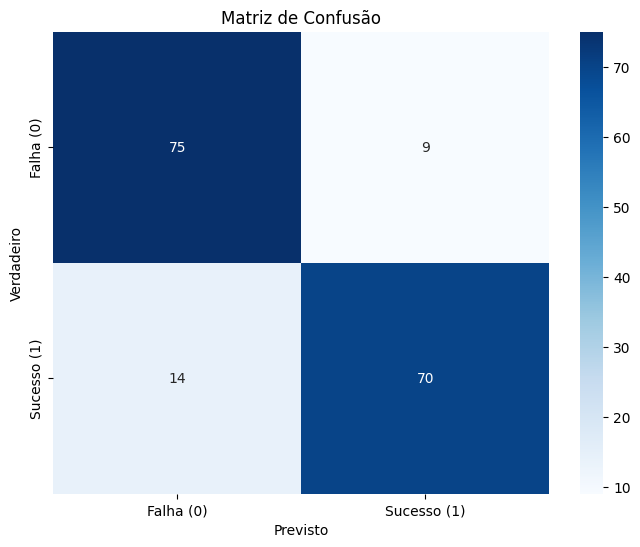

In [ ]:
# Calcular e exibir as métricas
print("--- Métricas de Avaliação no Conjunto de Validação ---")
print(f"Acurácia: {accuracy_score(y_val, val_predictions):.4f}\n")

print("Relatório de Classificação:")
print(classification_report(y_val, val_predictions))

# Gerar e visualizar a Matriz de Confusão
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_val, val_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Falha (0)', 'Sucesso (1)'], 
            yticklabels=['Falha (0)', 'Sucesso (1)'])
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

## Análise dos Resultados

**Acurácia:** O modelo atingiu uma acurácia de **0.8631** no conjunto de validação. Este é um resultado sólido e realista, indicando que o modelo não apenas memorizou os dados de treino, mas também conseguiu generalizar seu aprendizado para prever corretamente os resultados em dados novos.

**Relatório de Classificação:**
O relatório detalha a performance do modelo para cada classe, e podemos extrair insights importantes:

* **Classe 1 (Sucesso):**
    * **Alta Precisão (0.89):** Este é o ponto mais forte do modelo. Significa que, quando o modelo prevê que uma empresa terá **sucesso**, ele está correto em 89% das vezes. Para um investidor, isso é excelente, pois indica que as recomendações positivas do modelo são muito confiáveis e têm baixo risco de serem falsos alarmes.
    * **Bom Recall (0.83):** O modelo conseguiu identificar corretamente 83% de todas as empresas que realmente tiveram sucesso. Isso significa que ele pode "perder" algumas poucas oportunidades (17% dos sucessos não foram encontrados), mas ainda captura a grande maioria delas.

* **Classe 0 (Falha):**
    * **Alto Recall (0.89):** O modelo é muito bom em identificar as empresas que irão falhar, encontrando 89% delas. Isso é útil para evitar investimentos ruins.
    * **Boa Precisão (0.84):** Quando o modelo prevê "falha", ele acerta em 84% das vezes.


---

## 4.5. Geração do Arquivo de Submissão

**Objetivo:** Formatar as previsões no arquivo final para entrega.

**Motivo:** A etapa final consiste em pegar as previsões geradas pelo modelo e inseri-las na coluna `labels` de um DataFrame com o formato padrão de submissão. Este DataFrame é então salvo como `submission.csv`, concluindo o pipeline.

In [21]:
ensemble.fit(X_train, y_train)

predictions = ensemble.predict(X_test) 

# Criar o arquivo de submissão
submission = sample_submission.copy()
submission['labels'] = predictions
submission.to_csv('submission.csv', index=False)

print(f'\nArquivo criado com sucesso: submission.csv')
print(f'Número de previsões no arquivo: {len(predictions)}')


Arquivo criado com sucesso: submission.csv
Número de previsões no arquivo: 277
